In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython

In [3]:
%matplotlib inline

In [4]:
import os

modelname="5_7_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 d_model: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 ff_scalar: int = 2):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, d_model)
        #Positional encoding
        self.pos_encode = PositionalEncoding(d_model)

        self.decoder_layers = []
        
        bottleneck_size = d_model
        ff_size = ff_scalar*bottleneck_size

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(d_model, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            #Add bottleneck layer
            layer.append(nn.Linear(d_model, ff_size))
            #Now add bottleneck layer norm
            layer.append(nn.LayerNorm(ff_size))
            #Add feed forward
            layer.append(nn.Linear(ff_size, d_model))
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            
            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(d_model, n_features)
        
        
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_bottleneck = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            d_ff = decoder_layer[4]
            d_layer_norm_3 = decoder_layer[5]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)
            
            #do bottleneck
            res = d_bottleneck(res)
            #layer norm
            res = d_layer_norm_2(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_3(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0, split: str = "\n"):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte
        self.split = split

    def tokenize_str(self, sentence: str, encoding = "utf8") -> torch.Tensor:
        base = [int(i) for i in bytes(sentence, encoding)]
        if len(base) < self.n_pad:
            base.extend([self.pad_byte] * (self.n_pad - len(base)))
        assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding = "utf8") -> torch.Tensor:
        # tokenize the input text
        sentences = []
        for sentence in texts:
            sentences.append(self.tokenize_str(sentence).unsqueeze(0))

        return torch.cat(sentences, dim = 0).to(self.device)
    
    @staticmethod
    def prepare_texts(document: str) -> typing.List[str]:
        return filter(lambda x: len(x)!=0, document.split(self.split))
    
    def sequences_to_texts(self, texts: torch.Tensor, encoding = "utf8") -> typing.List[str]:
        out = []
        for seq in texts:
            chars = []
            i=0
            while i<len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i+=1
            out.append(bytes(chars).decode(encoding, "replace"))
        return out

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], n_pad):
        self.raw_data = data
        self.tokenizer = Tokenizer(n_pad, device, split = "\0")
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return self.tokenizer.tokenize_str(self.raw_data[index])

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode("utf8","replace")

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 768
batch_size = 32
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
print(f"Head size: {head_size}")
n_layers = 12

Head size: 12


In [15]:
path_to_data = "data/reddit_scrape_v8.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

187129


In [16]:
model = Transformer(d_model = embedding_dim, n_self_heads = head_size, n_features = n_features, n_layers = n_layers)
model=model.to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model), "trainable params")

57154816 trainable params


In [18]:
input=next(testloader_iter)
input=input.to(device)
print(input.shape)
res = model(input)
print(res.shape)

torch.Size([1, 512])
torch.Size([1, 512, 256])


In [19]:
lr = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [20]:
n_epochs = 40

In [21]:
!nvidia-smi

Sun May  7 11:21:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   60C    P0    68W / 150W |   1708MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
print(device)

cuda


In [23]:
prompts = [
    "Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.",
    "Hello world, ",
    "How to use ChatGPT? How should I use ChatGPT?",
    "My code does not work. What should I do? I have been working on my code, and it does not work.",
    "Why is this code not working: `1+\"A\"`? Can you help?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?",
    "What is coding?",
]

Epoch 1


  0%|          | 0/5848 [00:00<?, ?it/s]

=========================== BATCH 0 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, 


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?


Prompt 8: What is coding?
Model output (markdown): 

What is coding?


=========================== BATCH 500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. t the t t t t the t the the the t t t the the t t the the t the t the the the the the the the the the t t the the the the the the t the the the the the the t the the the the the the the the t the the the the the the the the the the the the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t the the t the the the the the the the the the the the the the t the the the the the the the the t the the the the the the the t the the the the the the the the the the the the the the

My code does not work. What should I do? I have been working on my code, and it does not work.


















































































I


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?












































































I


Prompt 5: Why is Java better than Python?
Model output (raw): Why is Java better than Python?






I t t t t t t t the t the t the the the the the the t t t the t the the t the the the the the the the the the the the the the the the the t the the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t the the the the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?







































































































































I


Prompt 8: What is coding?
Model output (raw): What is coding?


I t t the t the t t t the the the t the t t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

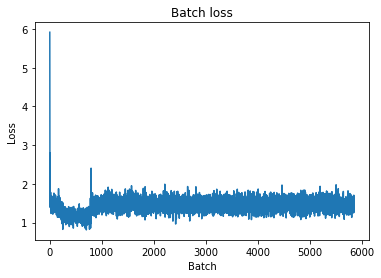

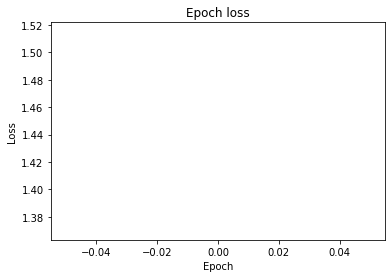

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/5848 [00:00<?, ?it/s]

=========================== BATCH 0 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

In [24]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    batch_test_output = []
    
    for batch, data in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        
        if batch % 500 == 0:
            print(f"=========================== BATCH {batch} ===========================")
            batch_test_output.append(f"=========================== BATCH {batch} ===========================")
            with torch.no_grad():
                for i, prompt in enumerate(prompts):
                    print(f"Prompt {i}: {prompt}")
                    output=generate(prompt)
                    batch_test_output.append(f"Prompt {i}: {prompt}"+"\n"+output)
                    if not output.strip().endswith("<CUTOFF>"):
                        print(f"Model output (markdown): ", end="")
                        IPython.display.display(IPython.display.Markdown(output))
                    else:
                        print(f"Model output (raw): {output}")
                    print()

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}.pt")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
        
    scheduler.step()    
    
    print("=========================== END OF EPOCH ===========================")
    batch_test_output.append("=========================== END OF EPOCH ===========================")
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            batch_test_output.append(f"Prompt {i}: {prompt}"+"\n"+output)
            if not output.strip().endswith("<CUTOFF>"):
                print(f"Model output (markdown): ", end="")
                IPython.display.display(IPython.display.Markdown(output))
            else:
                print(f"Model output (raw): {output}")
            print()


In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()